In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [29]:
#reading the csv document
salaries_df = pd.read_csv("ds_salaries.csv")
salaries_df.head()

,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_size
0,MI,CT,ML Engineer,30000,fully remote,S
1,MI,CT,ML Engineer,25500,fully remote,S
2,SE,FT,Applied Scientist,222200,hybrid,L
3,SE,FT,Applied Scientist,136000,hybrid,L
4,SE,FT,Data Scientist,147100,hybrid,M


35% moyenne de personne travaillant a la maison. même chose pour notre type de travail ("analyse de donnée")
est ce que notre doc est representatif de ceux qui travaillent que a la maison (est ce que 35% des gens dans ce csv sont 100 a la maison ?) ou alors pas representatif. 

on doit verifier a partir de remote_ratio. si j'ai fully remote c'est que le mec travail que a la maison. 

1a)
- H0 - 35% of the employees of Data profession work fully remote.
- H1 - less than 35% of the employees of Data profession work fully remote.

1b)
#### The test statistic is the percentage of remote workers in the sample

In [50]:
fully_hybrid = salaries_df[salaries_df['remote_ratio'] == 'hybrid'].count()
fully_remote = salaries_df[salaries_df['remote_ratio'] == 'fully remote'].count()
print(fully_hybrid, fully_remote)



experience_level    1057
employment_type     1057
job_title           1057
salary_in_usd       1057
remote_ratio        1057
company_size        1057
dtype: int64 experience_level    508
employment_type     508
job_title           508
salary_in_usd       508
remote_ratio        508
company_size        508
dtype: int64


p-value = 0.0199


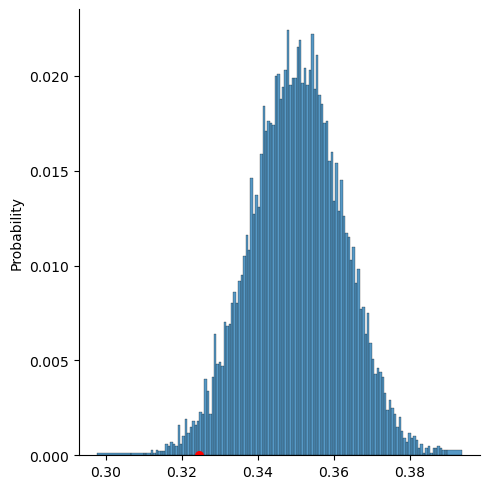

In [42]:
# compute the p-value
population = ['fully remote', 'hybrid']
prob_population = [0.35, 0.65] # probabilities of selection GIVEN THE MODEL IS TRUE
sample_size = salaries_df.shape[0]
num_of_remote_employees = salaries_df[salaries_df['remote_ratio'] == 'fully remote'].shape[0]


# sample one value
def sample_companies():
    sample_companies = np.random.choice(population, p=prob_population, size=sample_size)
    num_remote = np.count_nonzero(sample_companies == 'fully remote')
    return num_remote/sample_size

num_rep = 10000
samples = np.array([sample_companies() for i in range(num_rep)])

distirbution = sns.displot(samples, bins=np.unique(samples), stat='probability')
df_prob = num_of_remote_employees / sample_size
distirbution.axes[0,0].scatter(df_prob, 0, color='red', s=30)

p_value = np.count_nonzero(samples <= df_prob) / num_rep
print('p-value =', p_value)

In [6]:
def bootstarp_percentile(original_sample, column_name, num_replications):
    """Returns the percentile of the given column in the given dataframe
    using bootstrapping."""

    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_var_of_interest = original_sample[[column_name]] # the use of [[]] will return a df rather than series
    bstrap_percentile = np.empty(num_replications) # collection array for our estimates
    for i in range(num_replications):
        bootstrap_sample = original_sample_var_of_interest.sample(n=original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_percentile = np.count_nonzero(bootstrap_sample)*100/original_sample_size
        bstrap_percentile[i] = resampled_percentile
    
    return bstrap_percentile


1c) We are going to check the null hypothesys with a bootstrap method. 

In [8]:
def calculate_mean(sample, column_name, value_name):
    ''' This function return the mean value for a specific column, which contain non-numerical values, in a sample
    sample: df containing the sample
    column_name: the name of the column we want to calculate the mean
    value_name: the value whose average we want '''
    count = sample[column_name].value_counts()
    mean = count[value_name]/sample.shape[0]
    return mean
    
    
def bootstrap_mean(original_sample, column_name, num_replications, categorical = None):
    '''This function returns an array of bootstrapped sample means:
    original_sample: df containing the original sample
    column_name: name of column containing the variable of interest
    num_replications: number of bootstrap samples to draw
    categorical : The categorical name whose average we want'''
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_var_of_interest = original_sample[[column_name]] # the use of [[]] will return a df rather than series
    bstrap_means = np.empty(num_replications) # collection array for our estimates
    for i in range(num_replications):
        bootstrap_sample = original_sample_var_of_interest.sample(n=original_sample_size, replace=True) # note WITH REPLACEMENT!
        if(categorical is not None) :
            resampled_mean = calculate_mean(bootstrap_sample, column_name, categorical)
        else :
            resampled_mean = bootstrap_sample.mean()
        bstrap_means[i] = resampled_mean
    
    return bstrap_means

# run the bootstrap procedure and calculate the mean of fully_remote people in our original sample
means_bootstrapped = bootstrap_mean(salaries_df, 'remote_ratio', 5000, "fully remote")
population_mean = calculate_mean(salaries_df, "remote_ratio", "fully remote")

The 95% confidence interval for the population mean is between 30.095846645367413 and 34.82428115015974


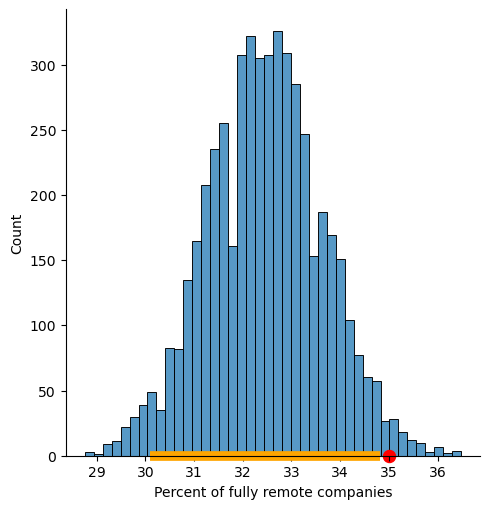

In [7]:
salaries_df["remote_ratio_boolean"] = salaries_df["remote_ratio"].apply(lambda x: 1 if x=="fully remote" else 0)
percentile_bootstrapped = bootstarp_percentile(salaries_df, "remote_ratio_boolean", 5000)

left_end = np.percentile(percentile_bootstrapped, 2.5, method="higher")
right_end = np.percentile(percentile_bootstrapped, 97.5, method="lower")
print("The 95% confidence interval for the population mean is between", left_end, 'and', right_end)

ax = sns.displot(percentile_bootstrapped)
ax.set(xlabel="Percent of fully remote companies")
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False)
plt.scatter(35, 0, marker='.', s=300, color='red', clip_on=False)  # draw observed value on the x-axis (at (8,0))


1d) Our conclusion is that we can reject the H0 under the conditions (with a condidence iterval of 95%)

The 95% boostsrap confidence interval is [0.3015974440894569, 0.3488817891373802]
The test statical is 0.35 isn't in the confidence interval


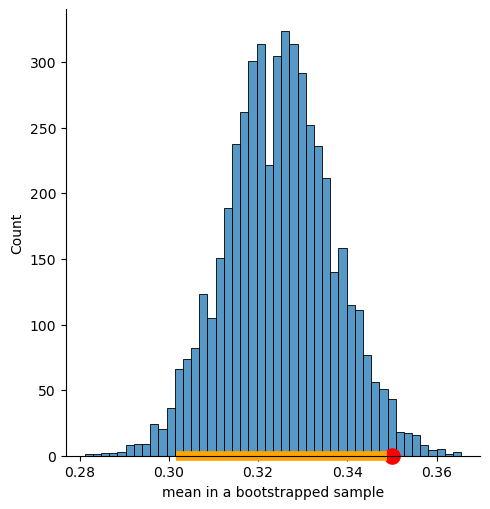

In [9]:

left_end = np.percentile(means_bootstrapped, 2.5, method='higher')
right_end =  np.percentile(means_bootstrapped, 97.5, method='higher')
# visualize results
print('The 95% boostsrap confidence interval is', [left_end,right_end])
print("The test statical is 0.35 isn't in the confidence interval")
ax1 = sns.displot(means_bootstrapped)
ax1.set(xlabel='mean in a bootstrapped sample')
plt.scatter(0.35, 0, color='red', s=120, clip_on=False) # the true value of the parameter (unknowable)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False)  # show line of values between 2.5 and 97.5 percentiles


2a)
  - 𝐻0 - The mean salary of Data Scientists is equal to the mean salary of Data Engineers
  - 𝐻1 - The mean salary of Data Scientists is NOT equal to the mean salary of Data Engineers

2b)
##### The static test is the mean of the salary of Data Scientists minus the mean of the salary of Data Engineers

2c) We are going to check the null hypothesys with a bootstrap method.

In [10]:
#creat a df with the two categoricals that we want
dataScientist_dataEngineer_df = salaries_df[(salaries_df['job_title'] == 'Data Scientist') | (salaries_df['job_title'] == 'Data Engineer')]
#calculate the mean for each one
## TODO: why?
mean_salary = dataScientist_dataEngineer_df.groupby('job_title')['salary_in_usd'].mean().reset_index()

# sns.catplot(data=dataScientist_dataEngineer_df, x='job_title', y='salary_in_usd', kind='bar')

In [11]:
def diff_of_avgs(df, column_name, grouping_var):
    '''This function returns the difference in averages
    df: the original df
    column_name: the name of the column that we are going to calculate the mean on
    grouping_var: the name of the column that we use to groupby'''
    grpby_var = df.groupby(grouping_var)
    avgs = grpby_var[column_name].mean()
    return avgs[1] - avgs[0]

def bootstrap_mean_difference(original_sample, column_name, grouping_var, num_replications):
    '''This function returns an array of bootstrapped differences between two sample averages:
      original_sample: df containing the original sample
      column_name: name of column containing the variable to average
      grouping_var: name of variable according to which to group
      num_replications: number of bootstrap samples'''
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_cols_of_interest = original_sample[[column_name, grouping_var]]
    bstrap_mean_diffs = np.empty(num_replications)
    for i in range(num_replications):
        bootstrap_sample = original_sample_cols_of_interest.sample(original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_mean_diff = diff_of_avgs(bootstrap_sample, column_name, grouping_var)
        bstrap_mean_diffs[i] = resampled_mean_diff
    
    return bstrap_mean_diffs

# run the bootstrap procedure
bstrap_diffs = bootstrap_mean_difference(dataScientist_dataEngineer_df, 'salary_in_usd', 'job_title',  5000)

The 99% boostsrap confidence interval is [3023.4542841537623, 22682.87075771697]
The 95% boostsrap confidence interval is [4800.108980150573, 20134.54039766558]


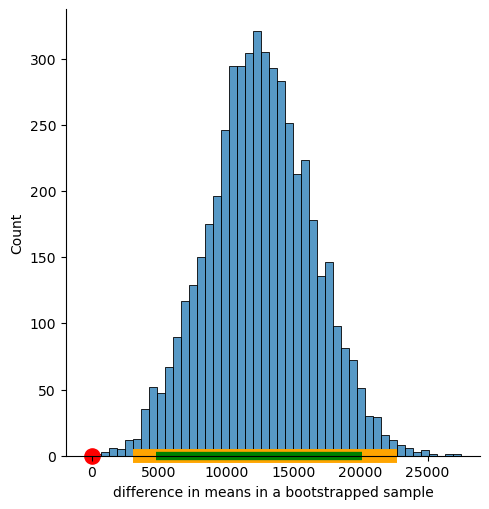

In [12]:
ax = sns.displot(bstrap_diffs)
ax.set(xlabel='difference in means in a bootstrapped sample')
confidence_interval = 1
color = 'orange'
plt.scatter(0, 0, color='red', s=120, clip_on=False) # the true value of the parameter (unknowable)

for i in range(2):
    left_end = np.percentile(bstrap_diffs, confidence_interval/2, method='higher')
    right_end =  np.percentile(bstrap_diffs, 100-confidence_interval/2, method='higher')
    print('The {}% boostsrap confidence interval is'.format(100-confidence_interval), [left_end,right_end])
    plt.hlines(y=0, xmin=left_end, xmax=right_end, colors=color, linestyles='solid', lw=10-4*i, clip_on=False)  # show line of values between 2.5 and 97.5 percentiles
    confidence_interval += 4
    color = 'green'

2d) 
 - The 95% boostsrap confidence interval for difference between population means is [5216.429760186904, 20289.565691578173]
 - The 99% boostsrap confidence interval for difference between population means [2708.3755672560073, 22431.525984626904]


The 95% boostsrap confidence interval for difference between population means [4800.108980150573, 20134.54039766558]


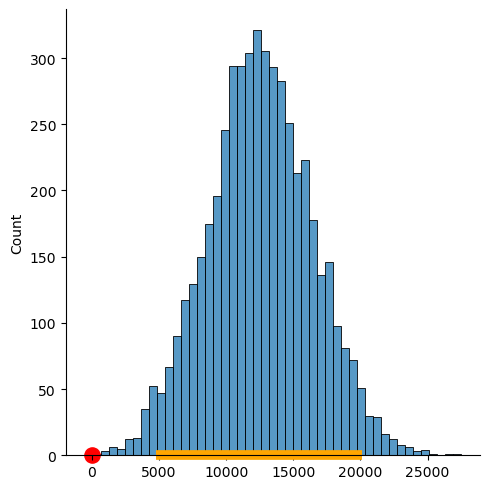

In [13]:
# Get the endpoints of the 95% confidence interval
left_end = np.percentile(bstrap_diffs, 2.5, method='higher')
right_end = np.percentile(bstrap_diffs, 97.5, method='higher')
print('The 95% boostsrap confidence interval for difference between population means', [left_end,right_end])

# visualize results
ax = sns.displot(bstrap_diffs)
plt.scatter(0, 0, color='red', s=120, clip_on=False)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False);  # show line of values between 2.5 and 97.5 percentiles

The 99% boostsrap confidence interval for difference between population means [3023.4542841537623, 22682.87075771697]


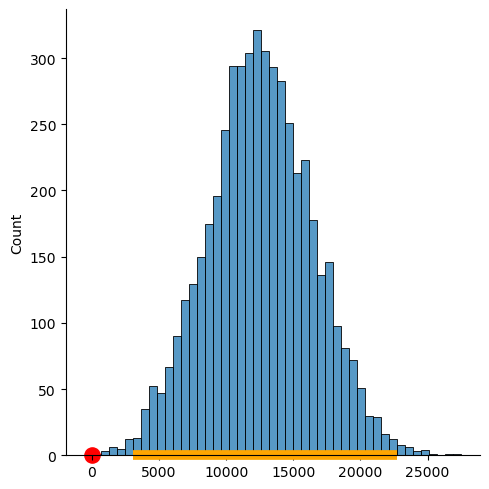

In [14]:
# Get the endpoints of the 99% confidence interval
left_end = np.percentile(bstrap_diffs, 0.5, method='higher')
right_end = np.percentile(bstrap_diffs, 99.5, method='higher')
print('The 99% boostsrap confidence interval for difference between population means', [left_end,right_end])

# visualize results
ax = sns.displot(bstrap_diffs)
plt.scatter(0, 0, color='red', s=120, clip_on=False)
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False);  # show line of values between 2.5 and 97.5 percentiles

2e) We counclude that we can reject the H0 in the different cases, because the expected value (0) isn't in the confidence interval no matter if it's 95% or 99%. In other word we can reject the fact that the salary's means are equals. 

3 ) The confidence interval of the mean salary of an employee in a company of size Medium is [153711.8287808128, 159382.3131245836]

In [15]:
#run the bootstrap procedure on a dataframe with exclusively medium company
sizeM_society_df = salaries_df[(salaries_df['company_size'] == 'M')]
means_bootstrapped_Msociety = bootstrap_mean(sizeM_society_df, 'salary_in_usd', 5000, False)

KeyError: False

In [16]:
# Get the endpoints of the 95% confidence interval
left_end = np.percentile(means_bootstrapped_Msociety, 2.5, method='higher')
right_end =  np.percentile(means_bootstrapped_Msociety, 97.5, method='higher')
print('The 95% boostsrap confidence interval is between', left_end, 'and', right_end)

# visualize results
ax1 = sns.displot(means_bootstrapped_Msociety)
ax1.set(xlabel='mean in a bootstrapped sample')
plt.hlines(y=0, xmin=left_end, xmax=right_end, colors='orange', linestyles='solid', lw=7, clip_on=False)  # show line of values between 2.5 and 97.5 percentiles


NameError: name 'means_bootstrapped_Msociety' is not defined

4a) For the 100's 95% bootstrap confidence intervals that we generate, the real median salary was included in 97 of them. 

In [ ]:
#calculate the median salary 
#create a df with exclusively hybrid's remote ratio 
real_median_salary = salaries_df["salary_in_usd"].median()
hybrid_df = salaries_df[(salaries_df['remote_ratio'] == 'hybrid')]


In [ ]:
# TODO: why?
def create_sample(hybrid_df, number_people):
    '''This function is create a sample of a certain size from a df
    hybrid_df: a df that we use to get a sample
    number_people: the size of the sample'''
    return hybrid_df.sample(n=number_people, replace=False)

def bootstrap_median(original_sample, column_name, num_replications):
    '''This function returns an array of bootstrapped sample medians:
    original_sample: df containing the original sample
    column_name: name of column containing the variable of interest
    num_replications: number of bootstrap samples to draw '''
    original_sample_size = original_sample.shape[0] # we need to replicate with the same sample size
    original_sample_var_of_interest = original_sample[[column_name]] # the use of [[]] will return a df rather than series
    bstrap_medians = np.empty(num_replications) # collection array for our estimates
    for i in range(num_replications):
        bootstrap_sample = original_sample_var_of_interest.sample(n=original_sample_size, replace=True) # note WITH REPLACEMENT!
        resampled_median = bootstrap_sample.quantile(0.5, interpolation='higher')
        bstrap_medians[i] = resampled_median
    
    return bstrap_medians

def real_median_in_confience_interval(bstrap_medians, real_median_salary) :
    '''This funciton return a bolean value, True if the median is in the confidence interval
    bstrap_median: an array of values from which we calculate the confidence interval
    real_median_salary: the number that we check if in the confidence interval'''
    left_end = np.percentile(bstrap_medians, 2.5, method='higher')
    right_end =  np.percentile(bstrap_medians, 97.5, method='higher')
    flag = False
    if (left_end < real_median_salary) & (real_median_salary < right_end):
        flag = True
    return flag

In [ ]:
#running the process 100 times
number_of_simulations = 100
size_of_sample = 150

median_in_confience_interval = np.empty(number_of_simulations)
for i in range(number_of_simulations):
    sample = create_sample(hybrid_df, size_of_sample)
    # sample = hybrid_df.sample(size_of_sample, replace=False)
    bstrap_median = bootstrap_median(sample, "salary_in_usd", 1000)
    median_in_confience_interval[i] = real_median_in_confience_interval(bstrap_median, real_median_salary)



In [ ]:
#checking the number of time with a True answer
count_true = np.count_nonzero(median_in_confience_interval)
print("Number of time that the real median floped in the confidence interval is :", count_true)

Number of time that the real median floped in the confidence interval is : 97


4b) No, as we've seen in the lecture, as in our case when the population is not random, the bootstrap method will not help us and will not provide us with a good confidence interval because the bootstrap method itself is based on the fact that the population is random.

4c)

112000.0


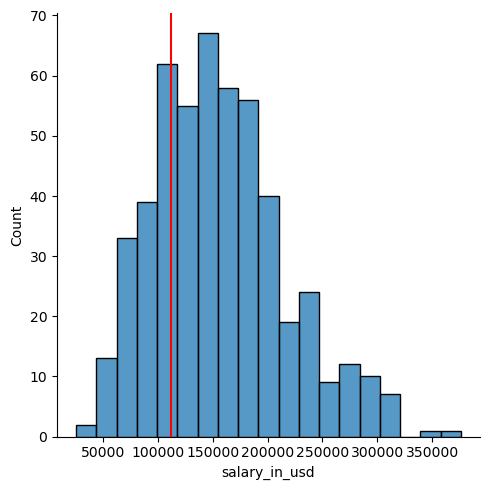

In [ ]:
fully_remote_df = salaries_df[(salaries_df['remote_ratio'] == 'fully remote')]
first_quartile_fully = fully_remote_df['salary_in_usd'].quantile(0.25)
print(first_quartile_fully)
ax1 = sns.displot(data=fully_remote_df, x='salary_in_usd')
plt.axvline(x=first_quartile_fully, color='red')
plt.show()

120000.0


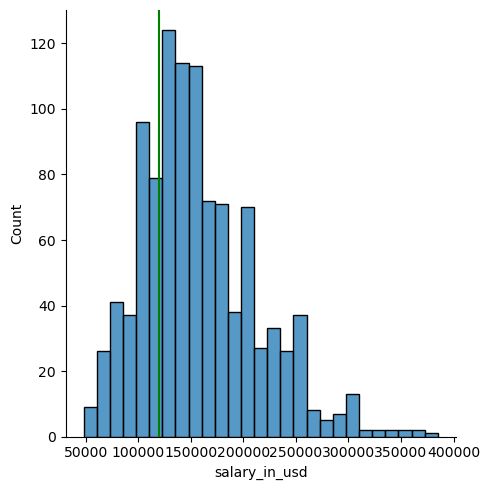

In [ ]:
first_quartile_hybrid = hybrid_df['salary_in_usd'].quantile(0.25)
print(first_quartile_hybrid)
ax2 = sns.displot(data=hybrid_df, x='salary_in_usd')
plt.axvline(x=first_quartile_hybrid, color='green')
plt.show()

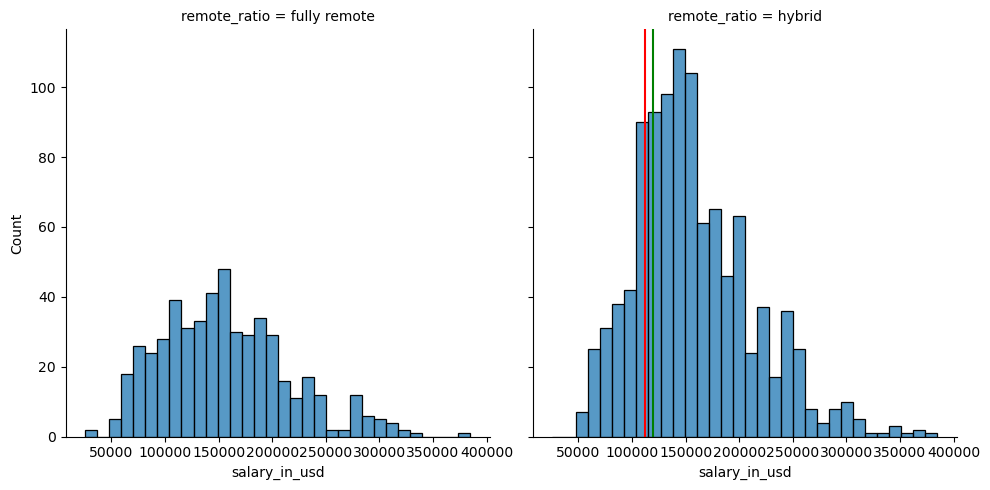

In [ ]:
# fig, ax = plt.subplots()
# salaries_df.plot(kind='bar', x='salary_in_usd', y='remote_ratio', ax=ax)
quartile_salary = sns.displot(data = salaries_df, x='salary_in_usd', col="remote_ratio")
plt.axvline(x=first_quartile_fully, color='red')
plt.axvline(x=first_quartile_hybrid, color='green')


## Part 2 :

1 ) 
With a very small sample, there may be increased bias in bootstrap estimates and higher variability in results. Due to the limited sample size, the generated bootstrap samples may not fully capture the true variability of the data, which may result in biased estimates or less precise confidence intervals.

1*)
With a small sample size, the bootstrap method may not represent the population well. The bootstrap method is based on the assumption that the sample is representative of the population. If the sample is not representative, the bootstrap method will not provide a good confidence interval.

2a) 